Epoch[1/25], G Loss: 2.7537, D Loss: 0.4282


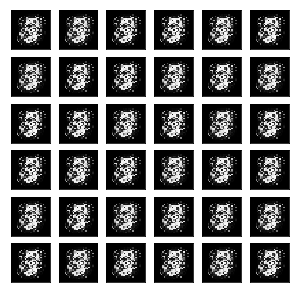

Epoch[2/25], G Loss: 3.1758, D Loss: 0.3496


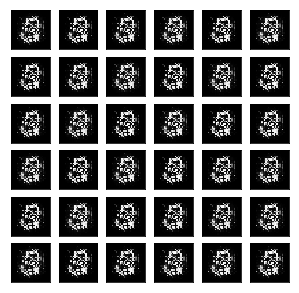

Epoch[3/25], G Loss: 3.5950, D Loss: 0.3491


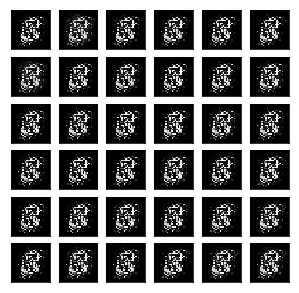

Epoch[4/25], G Loss: 4.0688, D Loss: 0.3536


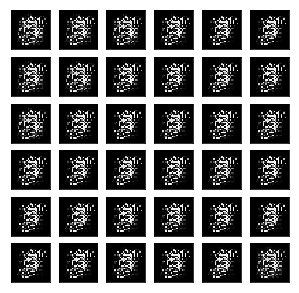

Epoch[5/25], G Loss: 4.7817, D Loss: 0.3417


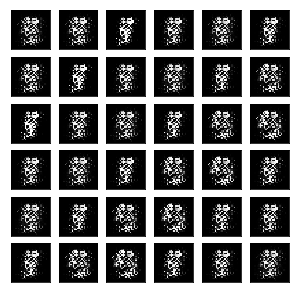

Epoch[6/25], G Loss: 4.5242, D Loss: 0.3368


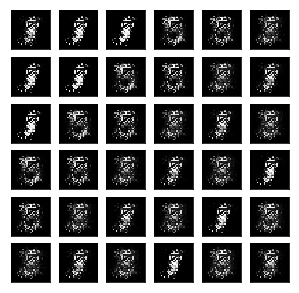

Epoch[7/25], G Loss: 3.2582, D Loss: 0.3572


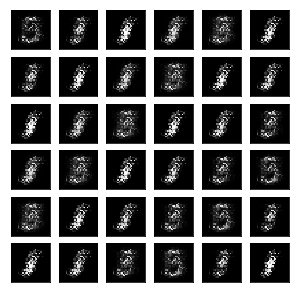

Epoch[8/25], G Loss: 3.2788, D Loss: 0.3876


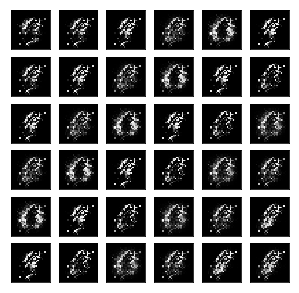

Epoch[9/25], G Loss: 4.2579, D Loss: 0.3570


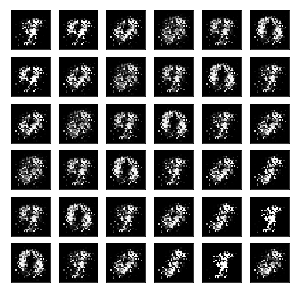

Epoch[10/25], G Loss: 4.5273, D Loss: 0.3791


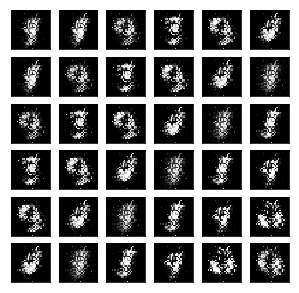

Epoch[11/25], G Loss: 3.9948, D Loss: 0.3839


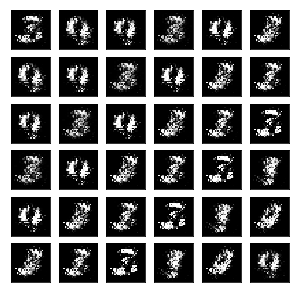

Epoch[12/25], G Loss: 3.9828, D Loss: 0.3855


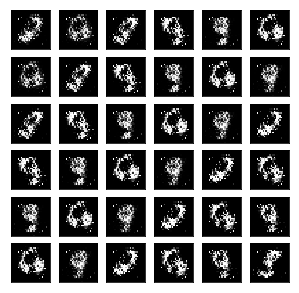

Epoch[13/25], G Loss: 4.0668, D Loss: 0.3970


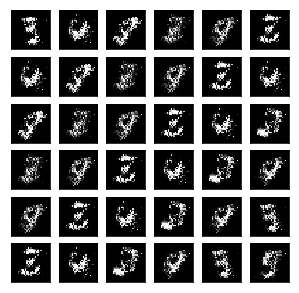

Epoch[14/25], G Loss: 4.1472, D Loss: 0.3991


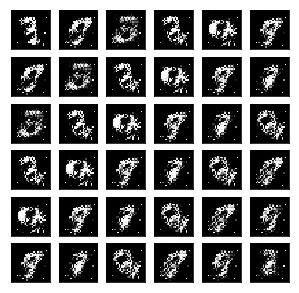

Epoch[15/25], G Loss: 4.3958, D Loss: 0.3699


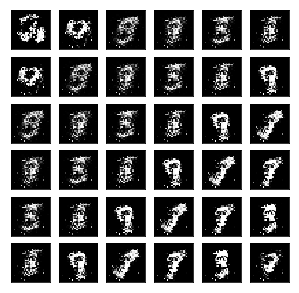

Epoch[16/25], G Loss: 4.3349, D Loss: 0.3758


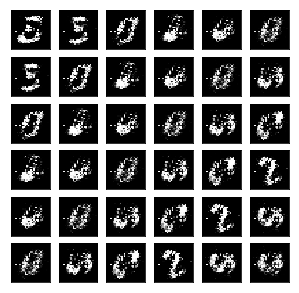

Epoch[17/25], G Loss: 4.2467, D Loss: 0.3787


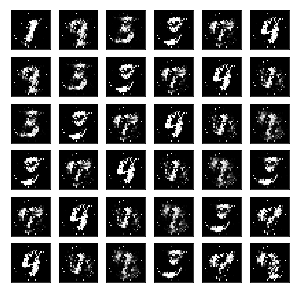

Epoch[18/25], G Loss: 4.2151, D Loss: 0.3786


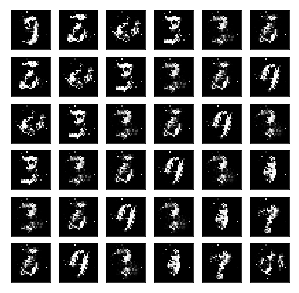

Epoch[19/25], G Loss: 4.5529, D Loss: 0.3694


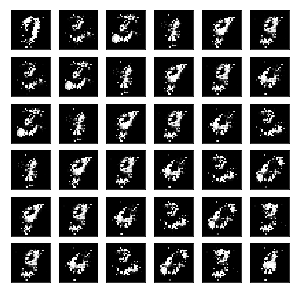

Epoch[20/25], G Loss: 4.9403, D Loss: 0.3566


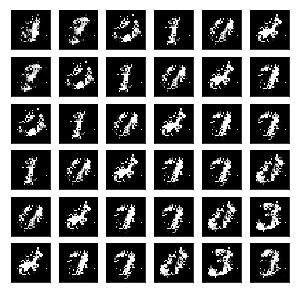

Epoch[21/25], G Loss: 5.0880, D Loss: 0.3584


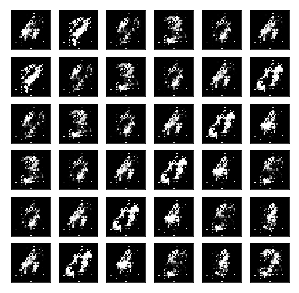

Epoch[22/25], G Loss: 5.1560, D Loss: 0.3637


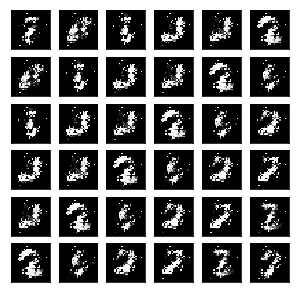

Epoch[23/25], G Loss: 5.1119, D Loss: 0.3640


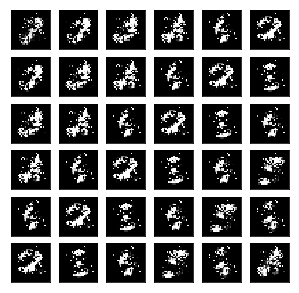

Epoch[24/25], G Loss: 5.6212, D Loss: 0.3599


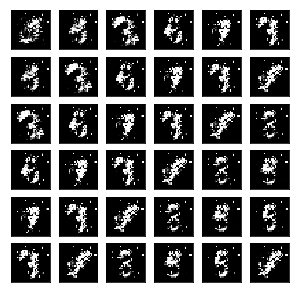

Epoch[25/25], G Loss: 5.7431, D Loss: 0.3643


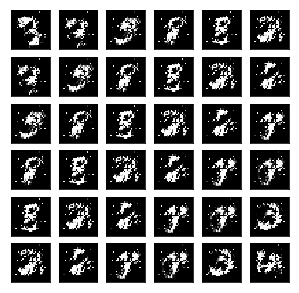

In [8]:
""" (RaGAN)
This implementation uses non-saturating (NS) GAN as a case study.

Relativistic GANs argue that the GAN generator should decrease the
discriminator's output probability that real data is real in addition to
increasing its output probability that fake data is real. By doing this, GANs
are claimed to be more stable and generate higher quality images.

Discriminator loss is changed such that the discriminator estimates the
probability that the given real data is more realistic than a randomly sampled
fake data. Generator loss is change such that real data is less likely to be
classified as real and fake data is more likely to be classified as real.

For computational efficiency, the discriminator estimates the probability that
the given real data is more realistic than fake data, on average. Otherwise, the
network would need to consider all combinations of real and fake data in the
minibatch. This would require O(m^2) instead of O(m), where m is batch size.

L(D) = -E[log( sigmoid(D(x) - E[D(G(z))]) )] - E[log(1 - sigmoid(D(G(z)) - E[D(x)]))]
L(G) = -E[log( sigmoid(D(G(z)) - E[D(x)]) )] - E[log(1 - sigmoid(D(x) - E[D(G(z))]))]

https://arxiv.org/pdf/1807.00734.pdf
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
# train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = torch.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Discriminator. Input is an image (real or generated), output is P(generated).
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = torch.sigmoid(self.discriminate(activated))
        return discrimination


class RaNSGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim

    
class RaNSGANTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz
            
    def train(self, num_epochs, G_lr=2e-4, D_lr=2e-4, D_steps=1):
        """ Train a vanilla GAN using the non-saturating gradients loss for the generator. 
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 2e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 2e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to learn to discriminate between real and generated images
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to generate images that fool the discriminator
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            self.num_epochs = epoch
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()
                
    def train_D(self, images):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: non-saturing loss for discriminator, 
            -E[log( sigmoid(D(x) - E[D(G(z))]) )] - E[log(1 - sigmoid(D(G(z)) - E[D(x)]))]
        """    
        # Generate labels (ones indicate real images, zeros indicate generated)
        X_labels = to_cuda(torch.ones(images.shape[0], 1))
        G_labels = to_cuda(torch.zeros(images.shape[0], 1))
        
        # Classify the real batch images, get the loss for these 
        DX_score = self.model.D(images)
        
        # Sample noise z, generate output G(z)
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = self.model.G(noise)
        
        # Classify the fake batch images, get the loss for these using sigmoid cross entropy
        DG_score = self.model.D(G_output)
        
        # Compute D loss
        DX_loss = F.binary_cross_entropy_with_logits(DX_score - torch.mean(DG_score), X_labels)
        DG_loss = F.binary_cross_entropy_with_logits(DG_score - torch.mean(DX_score), G_labels)
        D_loss = (DX_loss + DG_loss)/2
        
        return D_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: non-saturating loss for how well G(z) fools D, 
            -E[log( sigmoid(D(G(z)) - E[D(x)]) )] - E[log(1 - sigmoid(D(x) - E[D(G(z))]))]
        """        
        # Generate labels for the generator batch images (all 0, since they are fake)
        G_labels = to_cuda(torch.ones(images.shape[0], 1))
        
        # Get noise (denoted z), classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute the non-saturating loss for how D did versus the generations of G using sigmoid cross entropy
        G_loss = F.binary_cross_entropy(DG_score, G_labels)   

        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot Discriminator loss in red, Generator loss in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
        # Add legend, title
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = RaNSGAN(image_size=784, 
              hidden_dim=256, 
              z_dim=128)

trainer = RaNSGANTrainer(model=model, 
                       train_iter=train_iter, 
                       val_iter=val_iter, 
                       test_iter=test_iter,
                       viz=True)

trainer.train(num_epochs=25, 
              G_lr=2e-4, 
              D_lr=2e-4, 
              D_steps=1)